In [1]:
import pandas as pd
% load_ext autoreload
% autoreload 2

In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pytorch_lightning as pl
from data.flipped import FlippedLabels
from os import chdir
from glob import glob
from tqdm.notebook import tqdm
import numpy as np
from sklearn.metrics import roc_auc_score, roc_curve

chdir('/voyager/projects/tomginsberg/detectron')

In [3]:
def p_data(n=500, seed=0, cat=False):
    gen = torch.Generator()
    gen.manual_seed(seed)
    train_0 = banana(torch.randn(n, 2, generator=gen)) - torch.tensor([[1., 2.]])
    train_1 = banana(torch.randn(n, 2, generator=gen), -1) + torch.tensor([[1., 5.]])
    if cat:
        return torch.cat([train_0, train_1], dim=0).T
    return train_0.T, train_1.T


def q_data(n=500, seed=0):
    gen = torch.Generator()
    gen.manual_seed(seed)
    # return ((rotation_matrix(-.4)
    #          @ torch.tensor([[1 / 2, 0.], [0, 3]]) * 1 / 2
    #          @ torch.randn(2, n, generator=gen)).T + torch.tensor([[2.5, 4]])).T
    return ((rotation_matrix(-3.14)
             @ torch.tensor([[3, 0.], [0, 1]]) * 2 / 3
             @ torch.randn(2, n, generator=gen)).T + torch.tensor([[1, 2]])).T

In [4]:
def banana(X, b=1):
    """Twist the second column of X into a banana."""
    X[:, 1] += b * X[:, 0] ** 2
    return X

In [5]:
import math


def rotation_matrix(theta):
    """Return the rotation matrix for a given angle."""
    return torch.tensor([[math.cos(theta), -math.sin(theta)],
                         [math.sin(theta), math.cos(theta)]])

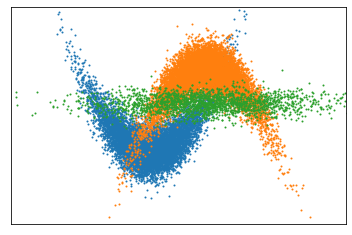

In [6]:
n = 10000
train_0, train_1 = p_data(n)
q = q_data(n=2000)

# plt.scatter(*marginal_samples(10000), s=1)

plt.scatter(*train_0, s=1)
plt.scatter(*train_1, 1)
plt.scatter(*q, 1)
plt.xticks([])
plt.yticks([])
plt.xlim(-6, 6)
plt.ylim(-8, 10);

In [7]:
from sklearn.neighbors import KernelDensity

X, Y = torch.cat([train_0, train_1], dim=-1)

In [8]:
kdeX = KernelDensity(kernel='gaussian', bandwidth=0.1)
kdeX.fit(X.numpy().reshape(-1, 1))

kdeY = KernelDensity(kernel='gaussian', bandwidth=0.1)
kdeY.fit(Y.numpy().reshape(-1, 1))

KernelDensity(bandwidth=0.1)

In [9]:
def marginal_samples(n, seed=0):
    x = kdeX.sample(n, random_state=seed)[:, 0]
    y = kdeY.sample(n, random_state=seed + 1)[:, 0]
    return torch.tensor([x, y])

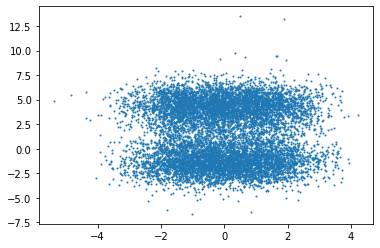

In [10]:
plt.scatter(*marginal_samples(10000), s=1)

In [11]:
from scipy.stats import ks_2samp

p = p_data(1000, seed=0, cat=True)
l = []
for seed in tqdm(range(10)):
    for n in range(1, 20):
        for shift in (True, False):
            if shift:
                q = q_data(n, seed)
            else:
                q = p_data(n, seed, cat=True)
            pv = min([ks_2samp(p[i], q[i]).pvalue for i in range(2)])
            l.append({'n': n, 'seed': seed, 'pvalue': pv, 'shift': shift})
df = pd.DataFrame(l)

  0%|          | 0/10 [00:00<?, ?it/s]

In [12]:
def roc_shift_score(s, n):
    """
    Score a shift detection algorithm with the area under the roc curve
    :param s:  list of pvalues for detection results when shift has occurred
    :param n:  list of pvalues for detection results when shift has not occurred
    :return:   roc score
    """
    return roc_auc_score(y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]),
                         y_score=(1 - np.concatenate([s, n])))


def roc_shift_curve(s, n):
    """
    Visualize a shift detection algorithm with the roc curve
    :param s:  list of pvalues for detection results when shift has occurred
    :param n:  list of pvalues for detection results when shift has not occurred
    :return:   fpr, tpr, fpr at 5%, tpr at 5%
    """
    fp, tp, _ = roc_curve(y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]),
                          y_score=(1 - np.concatenate([s, n])))
    return fp, tp, (np.asarray(n) < 0.05).mean(), (np.asarray(s) < 0.05).mean()

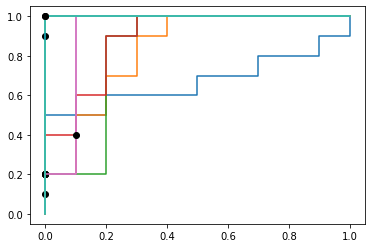

In [13]:
for k in range(1, 11):
    s = np.array(df.query('shift==True').query(f'n=={k}').pvalue)
    n = np.array(df.query('shift==False').query(f'n=={k}').pvalue)
    x = roc_shift_curve(s, n)
    plt.plot(x[0], x[1])
    plt.plot(x[2], x[3], 'o', color='black')

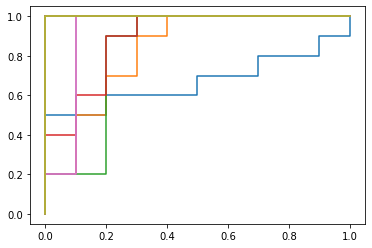

In [14]:
from sklearn.metrics import roc_auc_score, roc_curve

num_samples = []
scores = []
for k in list(df.n.unique()):
    s = np.array(df.query('shift==True').query(f'n=={k}').pvalue)
    n = np.array(df.query('shift==False').query(f'n=={k}').pvalue)

    fp, tp, _ = roc_curve(y_score=(1 - np.concatenate([s, n])),
                          y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
    score = roc_auc_score(y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]),
                          y_score=(1 - np.concatenate([s, n])))
    scores.append(score)
    num_samples.append(k)
    plt.plot(fp, tp, label=f'n={k}')

# plt.legend()

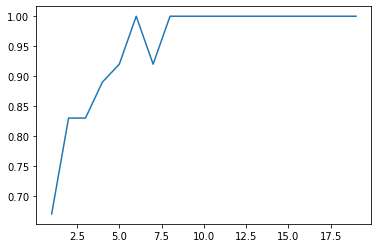

In [15]:
plt.plot(num_samples, scores)

In [29]:
class Data(Dataset):
    def __init__(self, n=500, train=True, seed=0):
        if train:
            n = n // 2
            self.train_0, self.train_1 = p_data(n, seed=seed)
            self.labels = torch.cat([torch.zeros(n), torch.ones(n)]).long()
            self.data = torch.cat([self.train_0.T, self.train_1.T])
        else:
            self.data = q_data(n, seed=seed + 1).T
            self.labels = Data.bayes_optimal(self.data)

    def __len__(self):
        return len(self.data)

    @staticmethod
    def bayes_optimal(data):
        a, b = data[:, 0], data[:, 1]
        E = math.exp(1.)
        return (E ** (-0.5 * (-1 + a) ** 2 - (-5 + (-1 + a) ** 2 + b) ** 2 / 2.) > E ** (
                -0.5 * (1 + a) ** 2 - (2 - (1 + a) ** 2 + b) ** 2 / 2.)).long()

    @staticmethod
    def bayes_likelihood(data):
        a, b = data[:, 0], data[:, 1]
        E = math.exp(1.)
        t = torch.stack([E ** (-0.5 * (-1 + a) ** 2 - (-5 + (-1 + a) ** 2 + b) ** 2 / 2.),
                         E ** (-0.5 * (1 + a) ** 2 - (2 - (1 + a) ** 2 + b) ** 2 / 2.)], dim=-1)
        return t

    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]


class DM(pl.LightningDataModule):
    def __init__(self, n_train=1000, n_test=100, n_val=100, train_seed=0, val_seed=1, test_seed=7,
                 shift=True,
                 negative_labels=True, n_pred=500, pred_seed=42):
        super().__init__()
        self.train = Data(n=n_train, train=True, seed=train_seed)
        self.val = Data(n=n_val, train=True, seed=val_seed)
        self.test = Data(n=n_test, train=False, seed=test_seed)
        if not shift:
            self.test = self.val
        if negative_labels:
            self.test = FlippedLabels(self.test)
        self.val = Data(n=n_val, train=True, seed=val_seed)
        self.predict = Data(n=n_pred, train=True, seed=pred_seed)

    def plot(self, ax=None):
        if ax is None:

            plt.scatter(*self.test.dataset.data.T, s=1, color='tab:orange')
            plt.scatter(*self.train.train_0, s=1, color='tab:red')
            plt.scatter(*self.train.train_1, s=1, color='tab:blue')
            plt.xlim(-6, 6)
            plt.ylim(-8, 10)
        else:
            ax.scatter(*self.test.dataset.data.T, marker='o', s=2, color='tab:orange', label='test')
            ax.scatter(*self.train.train_0, marker='o', s=2, color='tab:red', label='train$^{-}$')
            ax.scatter(*self.train.train_1, marker='o', s=2, color='tab:blue', label='train$^{+}$')
            ax.set_xlim(-6, 6)
            ax.set_ylim(-8, 10)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=32, shuffle=True, num_workers=4)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=32, shuffle=True, num_workers=4)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=32, shuffle=True, num_workers=4)

    def predict_dataloader(self):
        return DataLoader(self.predict, batch_size=32, shuffle=False, num_workers=4)

In [17]:
from models.model import Model


class MLP(Model):
    def __init__(self, in_features=2, out_features=2, hidden_features=[32, 64]):
        model = torch.nn.Sequential()
        fts = [in_features, *hidden_features, out_features]
        for i, ft in enumerate(fts[:-1]):
            model.add_module(f"linear_{i}", torch.nn.Linear(fts[i], fts[i + 1]))
            if i < len(hidden_features):
                model.add_module(f"relu_{i}", torch.nn.ReLU())
        self.save_hyperparameters()
        super().__init__(model=model, logger='accuracy', loss='ce', loss_params=None, optim='sgd',
                         optim_params={'lr': 0.01, 'momentum': 0.9},
                         scheduler=None, scheduler_params=None)

In [18]:
def plot_boundary(model, ax=None, label=None):
    # model: R^2 -> R^2
    x = torch.linspace(-6, 6, 100)
    y = torch.linspace(-8, 10, 100)
    x, y = torch.meshgrid(x, y)
    xy = torch.stack([x, y], dim=-1)
    xy = xy.reshape(xy.shape[0] * xy.shape[1], xy.shape[2])
    with torch.no_grad():
        pred = torch.softmax(model(xy), dim=1)[:, 1]
    pred = pred.reshape(x.shape[0], x.shape[1])
    if ax is None:
        plt.contour(x, y, pred, levels=[0.5], colors=['black'])
    else:
        CS = ax.contour(x, y, pred, levels=[0.5], colors=['black'])
        if label is not None:
            fmt = {CS.levels[0]: label}
            ax.clabel(CS, CS.levels, inline=True, fmt=fmt, fontsize=16)


In [19]:
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint

models = []
for seed in range(10):
    pl.seed_everything(seed)
    tr = pl.Trainer(max_epochs=100, gpus=1,
                    callbacks=[EarlyStopping(monitor='val_acc', patience=10, mode='max', verbose=True),
                               ModelCheckpoint(dirpath=f'checkpoints/banana/baselines',
                                               filename=f'{seed=}-' + '{val_acc:.2f}-{epoch}', monitor='val_acc',
                                               mode='max',
                                               save_top_k=1, verbose=True)])
    m = MLP(hidden_features=[32, 64, 128, 256])
    dm = DM(n_train=2000)
    tr.fit(m, dm)
    models.append(m)

Global seed set to 0


KeyboardInterrupt: 

In [19]:
models = []
for x in sorted(glob(f'checkpoints/banana/baselines/*')):
    m = MLP(hidden_features=[32, 64, 128, 256])
    m.load_state_dict(torch.load(x)['state_dict'])
    models.append(m)

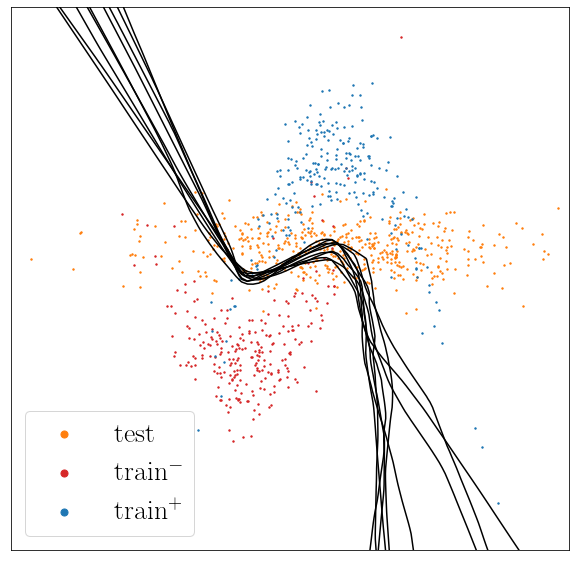

In [33]:
plt.rcParams['font.size'] = 28
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
for i, m in enumerate(models[:2] + models[3:]):
    plot_boundary(m.model, ax=ax)
DM(n_test=500, n_train=500).plot(ax=ax)
ax.set_xticks([])
ax.set_yticks([])
ax.legend(markerscale=5, loc='lower left')
plt.savefig('banana.pdf')

In [ ]:
from rejectron.training_utils import rejectron_trainer, train_rejectors

In [156]:
from shift_detection.ensemblemethods import EnsembleMethods
import numpy as np

In [157]:
def remove_bad_models(models):
    models = models[:2] + models[3:]
    return models

In [226]:
names = [f'{seed=}' for seed in range(10)]
en = EnsembleMethods(models=remove_bad_models(models), model_names=remove_bad_models(names),
                     datamodule=DM(n_pred=600, n_val=600, n_test=600),
                     df_path='tables/banana/bbsd',
                     logit_path='logits/banana', load_logits=False, baseline_samples=500)
en.ensemble_sweep(test_samples=[5, 10, 20, 30], test_seeds=range(500), shifts=(True, False))
en.bbsd_sweep(test_samples=[5, 10, 20, 30], test_seeds=range(100), shifts=(True, False))

Getting logits on 600 q samples on GPU cpu


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 41.16it/s]


Getting logits on 600 p samples on GPU cpu


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 44.91it/s]


Getting logits on 600 val samples on GPU cpu


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 19/19 [00:00<00:00, 45.91it/s]
9it [00:00, 188.67it/s]
9it [00:00, 187.50it/s]
9it [00:00, 176.75it/s]
9it [00:00, 191.29it/s]
9it [00:00, 149.32it/s]
9it [00:00, 155.33it/s]
9it [00:00, 153.98it/s]
9it [00:00, 155.63it/s]
9it [00:00, 158.21it/s]
9it [00:00, 157.49it/s]
9it [00:00, 157.54it/s]
9it [00:00, 158.84it/s]
9it [00:00, 156.31it/s]
9it [00:00, 157.99it/s]
9it [00:00, 156.36it/s]
9it [00:00, 133.32it/s]
9it [00:00, 141.77it/s]
9it [00:00, 154.62it/s]
9it [00:00, 155.21it/s]
9it [00:00, 155.35it/s]
9it [00:00, 152.07it/s]
9it [00:00, 154.54it/s]
9it [00:00, 151.06it/s]
9it [00:00, 154.25it/s]
9it [00:00, 155.34it/s]
9it [00:00, 154.11it/s]
9it [00:00, 155.85it/s]
9it [00:00, 154.68it/s]
9it [00:00, 153.84it/s]
9it [00:00, 152.61it/s]
9it [00:00, 151.86it/s]
9it [00:00, 152.82it/s]
9it [00:00, 157.22it/s]
9it [00:00, 156.79it/s]
9it [00:00, 153.01it/s]
9it [00:00, 15

In [35]:
en.print_results()

test_samples  shift  algorithm
10            False  bbsd         0.044444
                     ensemble     0.000000
              True   bbsd         0.216667
                     ensemble     0.200000
20            False  bbsd         0.077778
                     ensemble     0.000000
              True   bbsd         0.666667
                     ensemble     0.800000
50            False  bbsd         0.022222
                     ensemble     0.000000
              True   bbsd         1.000000
                     ensemble     1.000000
100           False  bbsd         0.000000
                     ensemble     0.000000
              True   bbsd         1.000000
                     ensemble     1.000000
Name: significant, dtype: float64


In [227]:
def query_pvals(algo, samples):
    df = en.df.query(f'algorithm=="{algo}" and test_samples=={samples}')
    s = np.array(df.query('shift==True').pvals)
    n = np.array(df.query('shift==False').pvals)
    if algo == 'bbsd':
        s = np.array([min(x) for x in s])
        n = np.array([min(x) for x in n])
    return s, n

In [160]:
from sklearn.metrics import roc_curve

In [21]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ['Computer Modern Roman'],
    'font.size': 16}
)

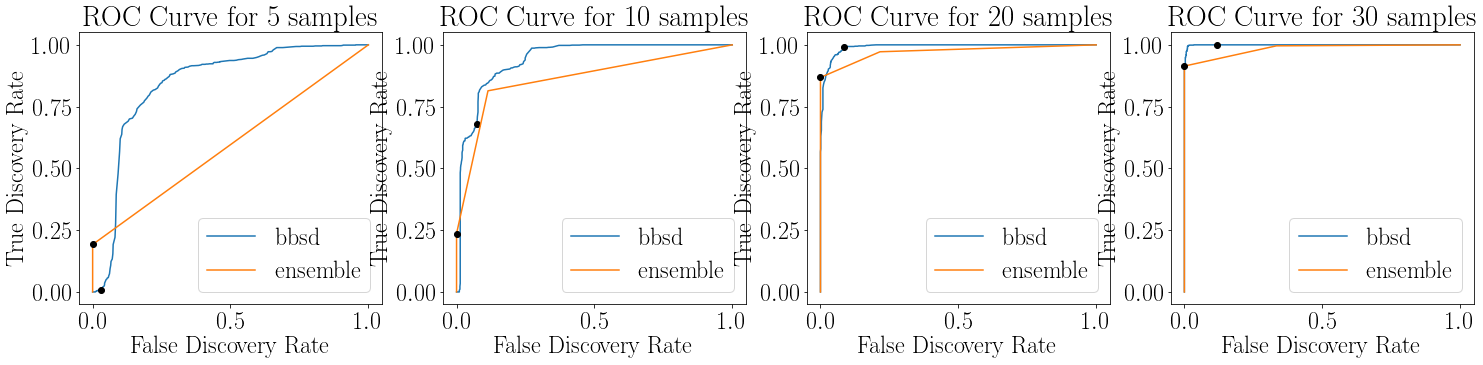

In [228]:
fig, axes = plt.subplots(1, 4, figsize=(25, 20 // 4))
for samples, ax in zip([5, 10, 20, 30], axes.ravel()):

    for algo in ['bbsd', 'ensemble']:
        s, n = query_pvals(algo, samples)
        fpr, tpr, thr = roc_curve(y_score=(1 - np.concatenate([s, n])),
                                  y_true=np.concatenate([np.ones(len(s)), np.zeros(len(n))]))
        ax.plot(fpr, tpr, label=algo)
        ax.plot((n < 0.05).mean(), (s < 0.05).mean(), 'o', color='black')

    ax.set_xlabel('False Discovery Rate')
    ax.set_ylabel('True Discovery Rate')
    ax.legend()
    ax.set_title(f'ROC Curve for {samples} samples')
# plt.savefig('roc_curves.pdf')

In [189]:
from data.subset import Subsetable


def complement(t1: torch.Tensor, t2: torch.Tensor) -> torch.Tensor:
    """
    :param t1:
    :param t2:
    :return: A tensor containing the elements of t1 that are not in t2.
    For efficiency, assumes t2 is a subset of t1
    """
    combined = torch.cat((t1, t2))
    uniques, counts = combined.unique(return_counts=True)
    complement = uniques[counts == 1]
    return complement


def k_folds(dataset: Dataset, split=(8, 2), k='all'):
    """
    Split the dataset into k folds.
    Where each fold is two datasets with split[0] and split[1] samples respectively
    the samples in the second dataset of each fold should be unique i.e. if x in folds[0][1]
    then x is not in folds[i][1] forall i!=1.
    :param dataset: torch dataset
    :param split: tuple (int, int), how many samples to use for training and validation
    :param k: how many folds to split the dataset into
    :return: [(dataset of split[0] samples, dataset of split[1] samples)] * k
    """
    assert (len(dataset)) >= (n := sum(split))
    if k == 'all':
        k = n // split[1]
    rng = torch.arange(n)
    val = torch.split(rng, split[1])
    train = [complement(rng, x) for x in val]
    return [[Subsetable.refined(dataset, i) for i in (t, v)] for t, v in zip(train, val)]

In [241]:
from rejectron.training_utils import rejectron_trainer, train_rejectors
from rejectron.pqmodule import PQModule

dm = DM(n_train=500, n_test=12, test_seed=4, n_val=300, n_pred=1000, shift=True, negative_labels=True)
folds = k_folds(dm.test, (8, 4))
trainer = rejectron_trainer(max_epochs=40, dryrun=True)
h = models[0]

In [246]:
C = []
df = pd.DataFrame()

from random import choice


def make_c():
    c = type(h)(**h.hparams)
    c.load_state_dict(choice(models).state_dict())
    c.train()
    return c


for fold in folds:
    pq = PQModule(p=dm.train, p_prime=dm.predict, q=fold[0], q_prime=fold[1], num_workers=4)
    df_, ref = train_rejectors(pq, h, make_c=make_c, trainer=trainer, num_rejectors=8, alpha=1)
    C.append(ref)
    df = df.append(df_)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


Benchmarking h


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9599999785423279,
 'val_acc_step': 0.9599999785423279,
 'val_loss_step': 0.15723595023155212}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9679999947547913,
 'val_acc_step': 0.9679999947547913,
 'val_loss_step': 0.114694744348526}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(Step=0,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                    | MLP             | 44.1 K
1 | c                    | MLP             | 44.1 K
2 | rejectron_metric     | RejectronMetric | 0     
3 | rejectron_metric_val | RejectronMetric | 0     
---------------------------------------------------------
88.1 K    Trainable params
0         Non-trainable params
88.1 K    Total params
0.353     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.875, 'val_acc_step': 0.875, 'val_loss_step': 0.33502545952796936}
--------------------------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0          1.0          0.0       0.96     0.875       10.0        1.0   

   val_acc  
0    0.968  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.025


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.025. Signaling Trainer to stop.


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.51it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 8, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000         0.00   0.960000  0.875000      10.00       1.00   
1   1.0        0.986         0.25   0.959432  0.857143      98.25       0.98   

    val_acc  
0  0.968000  
1  0.967347  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000         0.00   0.960000  0.875000      10.00      1.000   
1   1.0        0.986         0.25   0.959432  0.857143      98.25      0.980   
2   2.0        0.992         0.25   0.959677  0.833333      99.25      0.994   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 5
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000  0.875000     10.000      1.000   
1   1.0        0.986        0.250   0.959432  0.857143     98.250      0.980   
2   2.0        0.992        0.250   0.959677  0.833333     99.250      0.994   
3   3.0        0.992        0.375   0.959677  0.833333     99.375      0.992   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  
3  0.968750  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.020


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.020. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.57it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 5, |Q|_new = 5
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000  0.875000     10.000      1.000   
1   1.0        0.986        0.250   0.959432  0.857143     98.250      0.980   
2   2.0        0.992        0.250   0.959677  0.833333     99.250      0.994   
3   3.0        0.992        0.375   0.959677  0.833333     99.375      0.992   
4   4.0        0.996        0.375   0.959839  0.800000     99.375      0.993   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  
3  0.968750  
4  0.967774  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.66it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 5, |Q|_new = 5
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000  0.875000     10.000      1.000   
1   1.0        0.986        0.250   0.959432  0.857143     98.250      0.980   
2   2.0        0.992        0.250   0.959677  0.833333     99.250      0.994   
3   3.0        0.992        0.375   0.959677  0.833333     99.375      0.992   
4   4.0        0.996        0.375   0.959839  0.800000     99.375      0.993   
5   5.0        0.988        0.375   0.959514  0.800000     98.375      0.993   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  
3  0.968750  
4  0.967774  
5  0.967774  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.040 >= min_delta = 0.0. New best score: 99.040


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.040. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.72it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 5, |Q|_new = 5
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000  0.875000     10.000      1.000   
1   1.0        0.986        0.250   0.959432  0.857143     98.250      0.980   
2   2.0        0.992        0.250   0.959677  0.833333     99.250      0.994   
3   3.0        0.992        0.375   0.959677  0.833333     99.375      0.992   
4   4.0        0.996        0.375   0.959839  0.800000     99.375      0.993   
5   5.0        0.988        0.375   0.959514  0.800000     98.375      0.993   
6   6.0        0.992        0.375   0.959677  0.800000     99.375      0.986   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  
3  0.968750  
4  0.967774  
5  0.967774  
6  0.969574  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 96.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 97.000


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 98.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.040 >= min_delta = 0.0. New best score: 99.040


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.960 >= min_delta = 0.0. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.040 >= min_delta = 0.0. New best score: 100.040


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 5, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000  0.875000     10.000      1.000   
1   1.0        0.986        0.250   0.959432  0.857143     98.250      0.980   
2   2.0        0.992        0.250   0.959677  0.833333     99.250      0.994   
3   3.0        0.992        0.375   0.959677  0.833333     99.375      0.992   
4   4.0        0.996        0.375   0.959839  0.800000     99.375      0.993   
5   5.0        0.988        0.375   0.959514  0.800000     98.375      0.993   
6   6.0        0.992        0.375   0.959677  0.800000     99.375      0.986   
7   7.0        0.998        0.625   0.959920  1.000000     99.625      0.996   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  
3  0.968750  
4  0.967774  
5  0.967774  
6  0.969574  
7  0.971888  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
/tmp/ipykernel_62473/2840937018.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


|Q|_old = 3, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000  0.875000     10.000      1.000   
1   1.0        0.986        0.250   0.959432  0.857143     98.250      0.980   
2   2.0        0.992        0.250   0.959677  0.833333     99.250      0.994   
3   3.0        0.992        0.375   0.959677  0.833333     99.375      0.992   
4   4.0        0.996        0.375   0.959839  0.800000     99.375      0.993   
5   5.0        0.988        0.375   0.959514  0.800000     98.375      0.993   
6   6.0        0.992        0.375   0.959677  0.800000     99.375      0.986   
7   7.0        0.998        0.625   0.959920  1.000000     99.625      0.996   
8   8.0        0.988        0.625   0.959514  1.000000     98.625      0.992   

    val_acc  
0  0.968000  
1  0.967347  
2  0.967807  
3  0.968750  
4  0.967774  
5  0.967774  
6  0.969574  
7

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9599999785423279,
 'val_acc_step': 0.9599999785423279,
 'val_loss_step': 0.15723593533039093}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9679999947547913,
 'val_acc_step': 0.9679999947547913,
 'val_loss_step': 0.1146947368979454}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(Step=0,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                    | MLP             | 44.1 K
1 | c                    | MLP             | 44.1 K
2 | rejectron_metric     | RejectronMetric | 0     
3 | rejectron_metric_val | RejectronMetric | 0     
---------------------------------------------------------
88.1 K    Trainable params
0         Non-trainable params
88.1 K    Total params
0.353     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.875, 'val_acc_step': 0.875, 'val_loss_step': 0.302129864692688}
--------------------------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0          1.0          0.0       0.96     0.875       10.0        1.0   

   val_acc  
0    0.968  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 96.012


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.013 >= min_delta = 0.0. New best score: 96.025


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 97.025


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 98.025


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.012 >= min_delta = 0.0. New best score: 98.037


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.988 >= min_delta = 0.0. New best score: 99.025


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 0.012 >= min_delta = 0.0. New best score: 99.037


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.53it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 8, |Q|_new = 7
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000    0.96000     0.875     10.000      1.000   
1   1.0        0.998        0.125    0.95992     0.800     99.125      0.998   

    val_acc  
0  0.968000  
1  0.968938  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.029


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.029. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 7, |Q|_new = 5
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.020


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.020. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.73it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 5, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   
3   3.0        1.000        0.625   0.960000     0.750    100.625      0.984   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  
3  0.968496  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.92it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 3, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   
3   3.0        1.000        0.625   0.960000     0.750    100.625      0.984   
4   4.0        0.986        0.625   0.959432     1.000     98.625      0.988   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  
3  0.968496  
4  0.967611  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 3, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   
3   3.0        1.000        0.625   0.960000     0.750    100.625      0.984   
4   4.0        0.986        0.625   0.959432     1.000     98.625      0.988   
5   5.0        0.986        0.625   0.959432     1.000     98.625      0.984   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  
3  0.968496  
4  0.967611  
5  0.969512  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.71it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 3, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   
3   3.0        1.000        0.625   0.960000     0.750    100.625      0.984   
4   4.0        0.986        0.625   0.959432     1.000     98.625      0.988   
5   5.0        0.986        0.625   0.959432     1.000     98.625      0.984   
6   6.0        1.000        0.625   0.960000     1.000    100.625      0.992   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  
3  0.968496  
4  0.967611  
5  0.969512  
6  0.968750  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 96.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 97.000


Validating: 0it [00:00, ?it/s]

Metric p_q_score improved by 1.000 >= min_delta = 0.0. New best score: 98.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 98.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.94it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 3, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   
3   3.0        1.000        0.625   0.960000     0.750    100.625      0.984   
4   4.0        0.986        0.625   0.959432     1.000     98.625      0.988   
5   5.0        0.986        0.625   0.959432     1.000     98.625      0.984   
6   6.0        1.000        0.625   0.960000     1.000    100.625      0.992   
7   7.0        0.988        0.625   0.959514     1.000     98.625      0.989   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  
3  0.968496  
4  0.967611  
5  0.969512  
6  0.968750  
7  0.967644  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.56it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
/tmp/ipykernel_62473/2840937018.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


|Q|_old = 3, |Q|_new = 3
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000     0.875     10.000      1.000   
1   1.0        0.998        0.125   0.959920     0.800     99.125      0.998   
2   2.0        0.994        0.375   0.959759     0.800     99.375      0.988   
3   3.0        1.000        0.625   0.960000     0.750    100.625      0.984   
4   4.0        0.986        0.625   0.959432     1.000     98.625      0.988   
5   5.0        0.986        0.625   0.959432     1.000     98.625      0.984   
6   6.0        1.000        0.625   0.960000     1.000    100.625      0.992   
7   7.0        0.988        0.625   0.959514     1.000     98.625      0.989   
8   8.0        0.986        0.625   0.959432     1.000     98.625      0.988   

    val_acc  
0  0.968000  
1  0.968938  
2  0.969636  
3  0.968496  
4  0.967611  
5  0.969512  
6  0.968750  
7

/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9599999785423279,
 'val_acc_step': 0.9599999785423279,
 'val_loss_step': 0.15723592042922974}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 0.9679999947547913,
 'val_acc_step': 0.9679999947547913,
 'val_loss_step': 0.114694744348526}
--------------------------------------------------------------------------------


Validating: 0it [00:00, ?it/s]

/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:59: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(dict(Step=0,
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                    | MLP             | 44.1 K
1 | c                    | MLP             | 44.1 K
2 | rejectron_metric     | RejectronMetric | 0     
3 | rejectron_metric_val | RejectronMetric | 0     
---------------------------------------------------------
88.1 K    Trainable params
0         Non-trainable params
88.1 K    Total params
0.353     Total estimated model params size (MB)


--------------------------------------------------------------------------------
DATALOADER:0 VALIDATE RESULTS
{'val_acc': 1.0, 'val_acc_step': 1.0, 'val_loss_step': 0.1872720718383789}
--------------------------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0          1.0          0.0       0.96       1.0       10.0        1.0   

   val_acc  
0    0.968  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.000. Signaling Trainer to stop.


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.82it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 8, |Q|_new = 7
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   

    val_acc  
0  0.968000  
1  0.969543  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.80it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 7, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   
3   3.0        0.996        0.250   0.959839       1.0     99.250      0.985   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  
3  0.968528  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.61it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   
3   3.0        0.996        0.250   0.959839       1.0     99.250      0.985   
4   4.0        0.998        0.250   0.959920       1.0     99.250      0.993   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  
3  0.968528  
4  0.967774  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.78it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   
3   3.0        0.996        0.250   0.959839       1.0     99.250      0.985   
4   4.0        0.998        0.250   0.959920       1.0     99.250      0.993   
5   5.0        0.986        0.250   0.959432       1.0     98.250      0.984   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  
3  0.968528  
4  0.967774  
5  0.969512  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 100.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 100.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.93it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   
3   3.0        0.996        0.250   0.959839       1.0     99.250      0.985   
4   4.0        0.998        0.250   0.959920       1.0     99.250      0.993   
5   5.0        0.986        0.250   0.959432       1.0     98.250      0.984   
6   6.0        0.994        0.250   0.959759       1.0     99.250      0.986   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  
3  0.968528  
4  0.967774  
5  0.969512  
6  0.969574  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  2.64it/s]
/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.setup has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.setup.
  rank_zero_deprecation(
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3]

  | Name                 | Type            | Params
---------------------------------------------------------
0 | h                

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   
3   3.0        0.996        0.250   0.959839       1.0     99.250      0.985   
4   4.0        0.998        0.250   0.959920       1.0     99.250      0.993   
5   5.0        0.986        0.250   0.959432       1.0     98.250      0.984   
6   6.0        0.994        0.250   0.959759       1.0     99.250      0.986   
7   7.0        0.996        0.250   0.959839       1.0     99.250      0.985   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  
3  0.968528  
4  0.967774  
5  0.969512  
6  0.969574  
7  0.968528  


/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:631: UserWarning: Checkpoint directory /voyager/projects/tomginsberg/detectron/checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/trainer/data_loading.py:659: UserWarning: Your `val_dataloader` has `shuffle=True`, it is strongly recommended that you turn this off for val/test/predict dataloaders.
  rank_zero_warn(


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Metric p_q_score improved. New best score: 99.000


Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Monitored metric p_q_score did not improve in the last 15 records. Best score: 99.000. Signaling Trainer to stop.
/voyager/projects/tomginsberg/.conda/envs/pqlearning/lib/python3.9/site-packages/pytorch_lightning/core/datamodule.py:469: LightningDeprecationWarning: DataModule.teardown has already been called, so it will not be called again. In v1.6 this behavior will change to always call DataModule.teardown.
  rank_zero_deprecation(


------------------------------------------------------------
Refining Q


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  3.01it/s]

|Q|_old = 6, |Q|_new = 6
------------------------------------------------------------
   Step  train_agree  test_reject  train_acc  test_acc  p_q_score  val_agree  \
0   0.0        1.000        0.000   0.960000       1.0     10.000      1.000   
1   1.0        0.992        0.125   0.959677       1.0     99.125      0.985   
2   2.0        0.990        0.250   0.961616       1.0     99.250      0.983   
3   3.0        0.996        0.250   0.959839       1.0     99.250      0.985   
4   4.0        0.998        0.250   0.959920       1.0     99.250      0.993   
5   5.0        0.986        0.250   0.959432       1.0     98.250      0.984   
6   6.0        0.994        0.250   0.959759       1.0     99.250      0.986   
7   7.0        0.996        0.250   0.959839       1.0     99.250      0.985   
8   8.0        0.982        0.250   0.959267       1.0     98.250      0.986   

    val_acc  
0  0.968000  
1  0.969543  
2  0.970499  
3  0.968528  
4  0.967774  
5  0.969512  
6  0.969574  
7


/voyager/projects/tomginsberg/detectron/rejectron/training_utils.py:144: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(res, ignore_index=True)
/tmp/ipykernel_62473/2840937018.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df = df.append(df_)


In [192]:
def plot_fold(fold, ax=None):
    t, v = fold
    if ax is None:
        plt.plot(*torch.stack([x for x, _ in t]).T, 'o', color='blue')
        plt.plot(*torch.stack([x for x, _ in v]).T, 'o', color='red')
    else:
        ax.plot(*torch.stack([x for x, _ in t]).T, 'o', color='midnightblue')
        ax.plot(*torch.stack([x for x, _ in v]).T, 'o', color='tab:olive')

In [ ]:
fig, axs = plt.subplots(1, len(folds), figsize=(22, 20 // len(folds)))
for ax, f, cs in zip(axs.ravel(), folds, C):
    DM(n_test=5000, n_train=10000).plot(ax)
    for c in cs:
        plot_boundary(c, ax)
    plot_fold(f, ax)
    plot_boundary(h, ax)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('rejectors.pdf')